# Import necessary libraries

### Data visualization

### No Contrails in this image

## Data visualization with Contrails

### In this image we can see contrails appear

## Load & Preprocess Dataset

In [1]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Enable mixed precision for 2-3x speedup
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

base_path = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
train_path = f"{base_path}/train"

# Load patch IDs
patch_ids = os.listdir(train_path)
print(f"Found {len(patch_ids)} patches")

# SPEED OPTIMIZATION: Use only 25% of data for fast training
patch_ids = patch_ids[:len(patch_ids)//4]  # Use 5000 patches instead of 20000
print(f"Using {len(patch_ids)} patches for fast training")

2025-10-18 09:31:53.594790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760779913.811662      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760779913.876305      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 20529 patches
Using 5132 patches for fast training


In [2]:
def compute_band_stats(patch_ids, train_path, sample_size=50):
    """Compute global band statistics from a small sample"""
    band_mins = [np.inf] * 16
    band_maxs = [-np.inf] * 16
    
    sample_ids = np.random.choice(patch_ids, min(sample_size, len(patch_ids)), replace=False)
    
    for pid in tqdm(sample_ids, desc="Computing band stats"):
        patch_folder = os.path.join(train_path, pid)
        
        for b in range(16):
            band_path = os.path.join(patch_folder, f"band_{b+1:02d}.npy")
            if os.path.exists(band_path):
                band_data = np.load(band_path)
                band_mins[b] = min(band_mins[b], band_data.min())
                band_maxs[b] = max(band_maxs[b], band_data.max())
    
    return band_mins, band_maxs

# Compute statistics quickly
band_mins, band_maxs = compute_band_stats(patch_ids, train_path, sample_size=50)
print("Band statistics computed!")

Computing band stats: 100%|██████████| 50/50 [00:11<00:00,  4.23it/s]

Band statistics computed!


In [3]:
import random
import tensorflow as tf

def fast_generator(patch_ids, train_path, band_mins, band_maxs, batch_size=16, include_negatives=True):
    """Optimized generator with negative samples"""
    while True:
        shuffled_ids = patch_ids.copy()
        np.random.shuffle(shuffled_ids)
        
        for i in range(0, len(shuffled_ids), batch_size):
            batch_ids = shuffled_ids[i:i + batch_size]
            X_batch, y_batch = [], []
            
            for pid in batch_ids:
                patch_folder = os.path.join(train_path, pid)
                
                # Load bands
                bands = []
                for b in range(1, 17):
                    band_path = os.path.join(patch_folder, f"band_{b:02d}.npy")
                    if os.path.exists(band_path):
                        band_data = np.load(band_path)
                        # Normalize
                        band_norm = (band_data - band_mins[b-1]) / (band_maxs[b-1] - band_mins[b-1] + 1e-6)
                        bands.append(band_norm)
                
                if len(bands) != 16:
                    continue
                
                image = np.stack(bands, axis=-1)
                
                # Load mask
                mask_file = os.path.join(patch_folder, "human_pixel_masks.npy")
                if os.path.exists(mask_file):
                    mask = np.load(mask_file)
                    mask = np.expand_dims(mask, axis=-1)
                    
                    # Include positives and some negatives
                    if mask.sum() > 0 or (include_negatives and random.random() < 0.25):
                        # Apply augmentation
                        if random.random() > 0.5:
                            image = np.fliplr(image)
                            mask = np.fliplr(mask)
                        if random.random() > 0.5:
                            image = np.flipud(image)
                            mask = np.flipud(mask)
                        
                        X_batch.append(image)
                        y_batch.append(mask)
                
                if len(X_batch) >= batch_size:
                    break
            
            if len(X_batch) > 0:
                yield np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)

# Split data
train_ids, val_ids = train_test_split(patch_ids, test_size=0.2, random_state=42)

print(f"Train patches: {len(train_ids)}")
print(f"Validation patches: {len(val_ids)}")

# Calculate steps (reduced for speed)
train_steps = len(train_ids) // 16  # Batch size 16
val_steps = len(val_ids) // 16

# Cap steps for faster epochs
train_steps = min(train_steps, 300)  # Max 300 steps per epoch
val_steps = min(val_steps, 50)       # Max 50 validation steps

print(f"Train steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")

Train patches: 4105
Validation patches: 1027
Train steps per epoch: 256
Validation steps per epoch: 50


## Split into train & test

## Build U-Net Model

In [16]:
!ls -la /kaggle/input/google-research-identify-contrails-reduce-global-warming

total 17068
drwxr-xr-x     5 nobody nogroup        0 Oct 17 12:12 .
drwxr-xr-x     3 root   root        4096 Oct 18 09:31 ..
-rw-r--r--     1 nobody nogroup       76 Oct 17 11:43 sample_submission.csv
drwxr-xr-x     4 nobody nogroup        0 Oct 17 11:43 test
drwxr-xr-x 20531 nobody nogroup        0 Oct 17 12:10 train
-rw-r--r--     1 nobody nogroup 16018622 Oct 17 12:10 train_metadata.json
drwxr-xr-x  1858 nobody nogroup        0 Oct 17 12:12 validation
-rw-r--r--     1 nobody nogroup  1448528 Oct 17 12:12 validation_metadata.json


In [19]:
import json

with open("/kaggle/input/google-research-identify-contrails-reduce-global-warming/train_metadata.json") as f:
    meta = json.load(f)

print(type(meta))
print(len(meta))
print(meta[0])  # show one entry


<class 'list'>
20529
{'record_id': '3283699311323360356', 'projection_wkt': 'PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-51],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]', 'row_min': 1686563.5, 'row_size': -1960.975830078125, 'col_min': 371650.9375, 'col_size': 1947.1307373046875, 'timestamp': 1571008800.0}


TensorFlow version: 2.18.0
Loading metadata...
Training samples: 20529
Debugging first sample structure...

=== Debugging 3283699311323360356 ===
Files in directory: ['band_10.npy', 'band_14.npy', 'human_individual_masks.npy', 'band_15.npy', 'band_16.npy', 'band_08.npy', 'band_09.npy', 'band_13.npy', 'band_11.npy', 'human_pixel_masks.npy', 'band_12.npy']
  band_10.npy: shape=(256, 256, 8), dtype=float32, range=[196.604, 260.533]
  band_14.npy: shape=(256, 256, 8), dtype=float32, range=[197.584, 297.349]
  human_individual_masks.npy: shape=(256, 256, 1, 7), dtype=int32, range=[0.000, 0.000]
    Unique values: [0]
    Non-zero count: 0
  band_15.npy: shape=(256, 256, 8), dtype=float32, range=[195.960, 294.310]
  band_16.npy: shape=(256, 256, 8), dtype=float32, range=[197.816, 277.673]
  band_08.npy: shape=(256, 256, 8), dtype=float32, range=[196.444, 243.143]
  band_09.npy: shape=(256, 256, 8), dtype=float32, range=[195.850, 251.618]
  band_13.npy: shape=(256, 256, 8), dtype=float32, ran

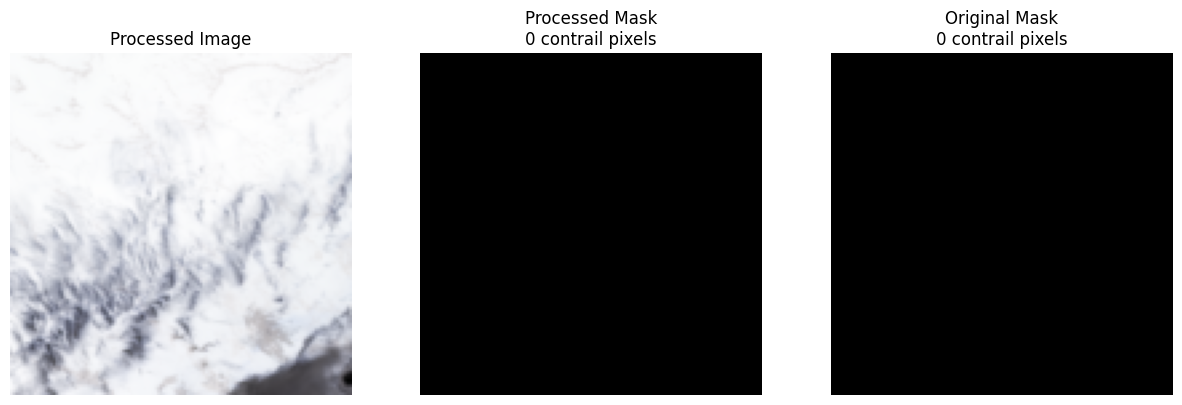

Searching for contrails in 1000 samples...


  1%|          | 10/1000 [00:00<00:10, 94.26it/s]

Loaded 3283699311323360356:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8563667897034605935:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6375533009500587038:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3029407526724839139:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4486503791474809647:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2127
Found contrails in 4

  3%|▎         | 30/1000 [00:00<00:11, 87.88it/s]

Loaded 3547701927462300733:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7453454703072928537:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 181
Found contrails in 7453454703072928537: 181 pixels
Loaded 1379296552884433298:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3835271611989816765:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 298
Found contrails in 3835271611989816765: 298 pixels
Loaded 8597889304036849:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256

  5%|▍         | 49/1000 [00:00<00:10, 89.03it/s]

  mask unique: [0 1]
  mask non-zero: 20
Found contrails in 7036826277932194282: 20 pixels
Loaded 449218378161126540:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 80788911023388669:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4539992924685641080:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3295399516602055588:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 58186347353608086:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks

  7%|▋         | 71/1000 [00:00<00:09, 95.99it/s]

Loaded 4010967022410875676:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 9133574868435112030:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3754138239264394354:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 246
Found contrails in 3754138239264394354: 246 pixels
Loaded 5392057290624772880:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 478551734703674075:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask un

  9%|▉         | 94/1000 [00:00<00:08, 104.22it/s]

Loaded 2895134045717759388:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7129928655637411281:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8587792011556997326:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 3825
Found contrails in 8587792011556997326: 3825 pixels
Loaded 7839268437877168575:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7045748036396132586:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask

 12%|█▏        | 117/1000 [00:01<00:08, 106.04it/s]

Loaded 1643561341996023895:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7317486793652090080:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2308144026411397124:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2283836158778922877:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 121
Found contrails in 2283836158778922877: 121 pixels
Loaded 5805771092193429731:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask u

 13%|█▎        | 128/1000 [00:01<00:08, 101.55it/s]

Loaded 5422962054394540844:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 541407870167174870:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 27
Found contrails in 541407870167174870: 27 pixels
Loaded 660183390182707550:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2710605185975275322:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 366743693852965151:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique:

 15%|█▌        | 151/1000 [00:01<00:08, 100.25it/s]

Loaded 5507158535789578958:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5797531605448261355:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6424143849037811179:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 620652916503548655:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2968334407315046073:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 3759
Found contrails in 29

 17%|█▋        | 172/1000 [00:01<00:08, 98.23it/s] 

Loaded 2587110542520292067:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 938769668853869379:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1978931258526393874:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4195897567869940995:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2721573934021454850:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8588265145829223722

 19%|█▉        | 193/1000 [00:02<00:08, 91.89it/s]

  mask unique: [0]
  mask non-zero: 0
Loaded 7625059188237551928:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 263
Found contrails in 7625059188237551928: 263 pixels
Loaded 7643518374588124053:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2419
Found contrails in 7643518374588124053: 2419 pixels
Loaded 6045380630451800759:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 954
Found contrails in 6045380630451800759: 954 pixels
Loaded 3040230679228255585:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 54855203

 20%|██        | 203/1000 [00:02<00:23, 34.05it/s]

Loaded 5252058093964379043:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3134855630433726964:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2319747724062812182:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 222
Found contrails in 2319747724062812182: 222 pixels
Loaded 832656124511757397:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 92
Found contrails in 832656124511757397: 92 pixels
Loaded 1068345722154278322:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256,

 21%|██        | 210/1000 [00:03<00:45, 17.36it/s]

Loaded 7121514209299385776:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2284242631714903682:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6347490394472604426:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4521229528315245528:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 178
Found contrails in 4521229528315245528: 178 pixels
Loaded 8703030635542598745:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask u

 22%|██▏       | 216/1000 [00:04<00:53, 14.58it/s]

Loaded 4476729056579184740:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 184
Found contrails in 4476729056579184740: 184 pixels
Loaded 8010444450514737161:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3810964597500295260:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 465
Found contrails in 3810964597500295260: 465 pixels


 22%|██▏       | 220/1000 [00:04<00:57, 13.53it/s]

Loaded 8746458521936557337:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 278
Found contrails in 8746458521936557337: 278 pixels
Loaded 3735579646489969444:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2316109827267714187:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8911895936051781486:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 251
Found contrails in 8911895936051781486: 251 pixels


 22%|██▏       | 223/1000 [00:05<00:59, 12.96it/s]

Loaded 5924458443057310958:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7829246608756777938:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6581607005385095496:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 23%|██▎       | 226/1000 [00:05<01:01, 12.69it/s]

Loaded 8672016761961923651:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 120531771160851723:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 179
Found contrails in 120531771160851723: 179 pixels
Loaded 8217260085618529326:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 23%|██▎       | 231/1000 [00:05<01:00, 12.66it/s]

Loaded 4326478270438511697:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 751169630681633778:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7344803385333990850:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 106
Found contrails in 7344803385333990850: 106 pixels


 23%|██▎       | 233/1000 [00:05<00:59, 12.92it/s]

Loaded 336825332625466936:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3750459503657280667:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 570456342692637031:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1748
Found contrails in 570456342692637031: 1748 pixels


 24%|██▎       | 237/1000 [00:06<00:58, 13.10it/s]

Loaded 4806331882021524665:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2330910415667440378:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 103
Found contrails in 2330910415667440378: 103 pixels
Loaded 1499904526596851551:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 24%|██▍       | 239/1000 [00:06<01:00, 12.54it/s]

Loaded 5888861995417067654:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 390
Found contrails in 5888861995417067654: 390 pixels
Loaded 1238158987297066666:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 919
Found contrails in 1238158987297066666: 919 pixels
Loaded 396793498164936485:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 24%|██▍       | 243/1000 [00:06<00:57, 13.09it/s]

Loaded 4443651296184873653:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8758131175348082347:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3597328968561763659:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 24%|██▍       | 245/1000 [00:06<01:01, 12.37it/s]

Loaded 5448219942030647963:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 127
Found contrails in 5448219942030647963: 127 pixels
Loaded 4675961907909630729:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 374
Found contrails in 4675961907909630729: 374 pixels
Loaded 5197826377924599080:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 25%|██▍       | 249/1000 [00:07<00:55, 13.58it/s]

Loaded 5867828719734075179:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1879
Found contrails in 5867828719734075179: 1879 pixels
Loaded 8815481059523017127:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 4004
Found contrails in 8815481059523017127: 4004 pixels
Loaded 7856623046367208697:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6412370967008594422:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1346
Found contrails in 6412370967008594422: 1346 pixels


 25%|██▌       | 253/1000 [00:07<00:58, 12.70it/s]

Loaded 3269692998022781850:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3812435084797004564:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8872134814910675656:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 26%|██▌       | 255/1000 [00:07<00:59, 12.51it/s]

Loaded 4656303865763691890:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4752863359103703190:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 186
Found contrails in 4752863359103703190: 186 pixels
Loaded 8356329120663211567:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 26%|██▌       | 259/1000 [00:08<00:58, 12.69it/s]

Loaded 737554047470254245:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 350
Found contrails in 737554047470254245: 350 pixels
Loaded 5899434678773417721:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1644
Found contrails in 5899434678773417721: 1644 pixels
Loaded 5108107037671245968:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 457
Found contrails in 5108107037671245968: 457 pixels


 26%|██▌       | 261/1000 [00:08<00:57, 12.78it/s]

Loaded 2146459876432679891:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 80
Found contrails in 2146459876432679891: 80 pixels
Loaded 650080396816349737:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 421
Found contrails in 650080396816349737: 421 pixels
Loaded 3045480556276606432:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 438
Found contrails in 3045480556276606432: 438 pixels


 26%|██▋       | 265/1000 [00:08<01:03, 11.61it/s]

Loaded 2071792222954264341:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 78
Found contrails in 2071792222954264341: 78 pixels
Loaded 5824985069385014242:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 73
Found contrails in 5824985069385014242: 73 pixels
Loaded 2715451995920144790:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 27%|██▋       | 267/1000 [00:08<01:03, 11.60it/s]

Loaded 7333268992711943050:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8620324890636595973:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8541185732031511079:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 27%|██▋       | 271/1000 [00:09<00:59, 12.21it/s]

Loaded 4569667681503712685:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 262
Found contrails in 4569667681503712685: 262 pixels
Loaded 5899761121880329456:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7570345990921815686:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 754
Found contrails in 7570345990921815686: 754 pixels


 27%|██▋       | 273/1000 [00:09<00:58, 12.43it/s]

Loaded 3956897194115295283:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8646703074106601942:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 228
Found contrails in 8646703074106601942: 228 pixels
Loaded 8578595598870445831:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1910
Found contrails in 8578595598870445831: 1910 pixels


 28%|██▊       | 277/1000 [00:09<01:00, 11.92it/s]

Loaded 2856119116558679668:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 763
Found contrails in 2856119116558679668: 763 pixels
Loaded 7886102093526775590:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 974
Found contrails in 7886102093526775590: 974 pixels
Loaded 6340539880744494620:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 28%|██▊       | 279/1000 [00:09<00:59, 12.13it/s]

Loaded 9155663314111408873:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 3278
Found contrails in 9155663314111408873: 3278 pixels
Loaded 2260453104053756051:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8089868772800951290:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 28%|██▊       | 283/1000 [00:10<01:03, 11.38it/s]

Loaded 7961970061516401393:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1142
Found contrails in 7961970061516401393: 1142 pixels
Loaded 6580480656067154372:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 192
Found contrails in 6580480656067154372: 192 pixels
Loaded 587612282038978889:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 28%|██▊       | 285/1000 [00:10<01:03, 11.31it/s]

Loaded 1762983178580756269:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 299
Found contrails in 1762983178580756269: 299 pixels
Loaded 938440444979966352:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 80
Found contrails in 938440444979966352: 80 pixels
Loaded 8828675122746290751:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 168
Found contrails in 8828675122746290751: 168 pixels


 29%|██▉       | 289/1000 [00:10<01:01, 11.63it/s]

Loaded 3775411292292607672:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1548
Found contrails in 3775411292292607672: 1548 pixels
Loaded 5116373701397424965:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1288
Found contrails in 5116373701397424965: 1288 pixels
Loaded 2214531367030628759:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 539
Found contrails in 2214531367030628759: 539 pixels


 29%|██▉       | 291/1000 [00:10<01:02, 11.35it/s]

Loaded 7108864904413908372:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 883792755559380656:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4980240298144578050:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 30%|██▉       | 295/1000 [00:11<01:00, 11.64it/s]

Loaded 5342577176406475552:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 129
Found contrails in 5342577176406475552: 129 pixels
Loaded 17506550900166133:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1301015985032275226:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 799
Found contrails in 1301015985032275226: 799 pixels


 30%|██▉       | 297/1000 [00:11<01:00, 11.70it/s]

Loaded 9193061742185459497:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 45
Found contrails in 9193061742185459497: 45 pixels
Loaded 7903989209670114493:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 645
Found contrails in 7903989209670114493: 645 pixels
Loaded 3123082891575791424:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 187
Found contrails in 3123082891575791424: 187 pixels


 30%|███       | 301/1000 [00:11<00:59, 11.77it/s]

Loaded 744947987128616340:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4909497043942987732:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3190570245344350639:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 30%|███       | 303/1000 [00:11<00:55, 12.56it/s]

Loaded 572838901328432363:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1822
Found contrails in 572838901328432363: 1822 pixels
Loaded 1658471071449963142:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1079301347462854183:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 31%|███       | 307/1000 [00:12<00:55, 12.47it/s]

Loaded 4448473604850460035:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 29
Found contrails in 4448473604850460035: 29 pixels
Loaded 759837663324851678:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2319980131910305585:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 319
Found contrails in 2319980131910305585: 319 pixels


 31%|███       | 309/1000 [00:12<00:54, 12.60it/s]

Loaded 8633753254846681387:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 922
Found contrails in 8633753254846681387: 922 pixels
Loaded 8835802229362713032:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 43
Found contrails in 8835802229362713032: 43 pixels
Loaded 3760095708854570491:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 632
Found contrails in 3760095708854570491: 632 pixels


 31%|███▏      | 313/1000 [00:12<00:54, 12.69it/s]

Loaded 2504728284792818024:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2835078325415097749:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 52
Found contrails in 2835078325415097749: 52 pixels
Loaded 660825833122123893:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 797
Found contrails in 660825833122123893: 797 pixels


 32%|███▏      | 315/1000 [00:12<01:00, 11.40it/s]

Loaded 237862538971961254:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5018150577417917935:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8943842305891357637:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 32%|███▏      | 317/1000 [00:12<00:53, 12.70it/s]

Loaded 2450512322487660358:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7287602709698297199:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 3893
Found contrails in 7287602709698297199: 3893 pixels
Loaded 4359308687545759773:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32


 32%|███▏      | 319/1000 [00:13<00:58, 11.58it/s]

  mask unique: [0 1]
  mask non-zero: 61
Found contrails in 4359308687545759773: 61 pixels
Loaded 8430250777951749932:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 4805
Found contrails in 8430250777951749932: 4805 pixels
Loaded 4064238382884907331:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 970
Found contrails in 4064238382884907331: 970 pixels


 32%|███▏      | 323/1000 [00:13<01:01, 10.93it/s]

Loaded 2676972723895285971:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 23
Found contrails in 2676972723895285971: 23 pixels
Loaded 853084931322332950:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 389
Found contrails in 853084931322332950: 389 pixels
Loaded 2933968942245534572:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 33%|███▎      | 327/1000 [00:13<00:57, 11.80it/s]

Loaded 4327371812342649796:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1389
Found contrails in 4327371812342649796: 1389 pixels
Loaded 4835959209638017577:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 610611686758687423:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 468
Found contrails in 610611686758687423: 468 pixels


 33%|███▎      | 329/1000 [00:13<00:56, 11.90it/s]

Loaded 6172505894569367579:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8619199814492252120:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7036708265481785264:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 33%|███▎      | 333/1000 [00:14<00:52, 12.79it/s]

Loaded 8464500901235093731:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7222384198040281261:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8157278158847176079:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 34%|███▎      | 335/1000 [00:14<00:55, 11.97it/s]

Loaded 5945130668308517983:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 891
Found contrails in 5945130668308517983: 891 pixels
Loaded 6125945477469325229:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7773250718413322239:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 47
Found contrails in 7773250718413322239: 47 pixels


 34%|███▍      | 339/1000 [00:14<00:51, 12.87it/s]

Loaded 8130546956675772122:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 310222191011099425:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2110058635053036823:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 532
Found contrails in 2110058635053036823: 532 pixels


 34%|███▍      | 343/1000 [00:14<00:48, 13.65it/s]

Loaded 6882360077882982996:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4154257126528626055:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 128
Found contrails in 4154257126528626055: 128 pixels
Loaded 7875114690790220650:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 885
Found contrails in 7875114690790220650: 885 pixels
Loaded 2903700676378840939:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 34%|███▍      | 345/1000 [00:15<00:48, 13.58it/s]

Loaded 1462604490105212669:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 9177053336700484425:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4867595767538246691:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2019
Found contrails in 4867595767538246691: 2019 pixels


 35%|███▍      | 349/1000 [00:15<00:52, 12.51it/s]

Loaded 8078862183979577337:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 598452695126734962:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6834333872661663375:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 408
Found contrails in 6834333872661663375: 408 pixels


 35%|███▌      | 351/1000 [00:15<00:53, 12.02it/s]

Loaded 3635197209296861763:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7166064559999103098:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 708
Found contrails in 7166064559999103098: 708 pixels
Loaded 4083808235368888492:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1007
Found contrails in 4083808235368888492: 1007 pixels


 36%|███▌      | 355/1000 [00:16<00:57, 11.20it/s]

Loaded 9101215662615145728:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6045580498120176829:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 398
Found contrails in 6045580498120176829: 398 pixels
Loaded 6268462426775476481:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 36%|███▌      | 357/1000 [00:16<00:56, 11.31it/s]

Loaded 4315601960253645243:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7558643589773653253:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4219393768730295439:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 36%|███▌      | 361/1000 [00:16<00:56, 11.39it/s]

Loaded 4511255975071359346:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 204
Found contrails in 4511255975071359346: 204 pixels
Loaded 3354056119213905163:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8436531063762655356:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 260
Found contrails in 8436531063762655356: 260 pixels


 36%|███▋      | 363/1000 [00:16<00:50, 12.55it/s]

Loaded 6077490465823002428:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6986627124210322724:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8436861119962233065:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 45
Found contrails in 8436861119962233065: 45 pixels


 37%|███▋      | 367/1000 [00:17<00:54, 11.59it/s]

Loaded 6995791458191730570:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1046
Found contrails in 6995791458191730570: 1046 pixels
Loaded 7211935488155997483:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1129
Found contrails in 7211935488155997483: 1129 pixels
Loaded 4836687993785277963:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 37%|███▋      | 369/1000 [00:17<00:51, 12.21it/s]

Loaded 7597706500305840435:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7367231470784917837:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5209550332281621599:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 37%|███▋      | 373/1000 [00:17<00:49, 12.80it/s]

Loaded 4438541431866151171:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 700
Found contrails in 4438541431866151171: 700 pixels
Loaded 4556684469922339366:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8278346077105240826:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 38%|███▊      | 375/1000 [00:17<00:51, 12.23it/s]

Loaded 4524348276472685840:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1830870968923864727:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 95
Found contrails in 1830870968923864727: 95 pixels
Loaded 8401717915296572895:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 312
Found contrails in 8401717915296572895: 312 pixels


 38%|███▊      | 379/1000 [00:17<00:47, 13.00it/s]

Loaded 6768255172961301162:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 256
Found contrails in 6768255172961301162: 256 pixels
Loaded 9038896762507421690:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1459351427826228444:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 704
Found contrails in 1459351427826228444: 704 pixels


 38%|███▊      | 381/1000 [00:18<00:51, 12.07it/s]

Loaded 3593040541090472443:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 297
Found contrails in 3593040541090472443: 297 pixels
Loaded 8436537857474825260:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 853
Found contrails in 8436537857474825260: 853 pixels
Loaded 6669242007226318288:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 38%|███▊      | 385/1000 [00:18<00:49, 12.35it/s]

Loaded 6604321298779403946:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 44
Found contrails in 6604321298779403946: 44 pixels
Loaded 6521270377666467645:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1157
Found contrails in 6521270377666467645: 1157 pixels
Loaded 2868432120464396356:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 591
Found contrails in 2868432120464396356: 591 pixels


 39%|███▊      | 387/1000 [00:18<00:50, 12.06it/s]

Loaded 986158342061410556:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5221948275186497878:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5567806357303456760:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2591
Found contrails in 5567806357303456760: 2591 pixels


 39%|███▉      | 391/1000 [00:19<00:52, 11.67it/s]

Loaded 1105727829006004052:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1674946648344622746:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 76872518830415868:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 39%|███▉      | 393/1000 [00:19<00:51, 11.84it/s]

Loaded 2592561383778062548:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8392138891228762389:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6064346786821592085:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2328838126661187335:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 898
Found contrails in 2328838126661187335: 898 pixels


 40%|███▉      | 397/1000 [00:19<00:44, 13.66it/s]

Loaded 5363810429195097596:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 836
Found contrails in 5363810429195097596: 836 pixels
Loaded 8824780082406966023:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 9121847268097354236:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 673
Found contrails in 9121847268097354236: 673 pixels


 40%|████      | 401/1000 [00:19<00:46, 12.84it/s]

Loaded 4908736394905223425:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 543406509814388247:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8982132913825700868:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 588
Found contrails in 8982132913825700868: 588 pixels


 40%|████      | 403/1000 [00:19<00:46, 12.86it/s]

Loaded 5414324646447969626:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 137
Found contrails in 5414324646447969626: 137 pixels
Loaded 1322527762960041953:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1803478354331490993:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 802
Found contrails in 1803478354331490993: 802 pixels


 41%|████      | 407/1000 [00:20<00:45, 13.07it/s]

Loaded 3468965306092600989:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 925655255201028465:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 9152970089864812542:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 41%|████      | 409/1000 [00:20<00:48, 12.21it/s]

Loaded 8519119750219390242:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 474
Found contrails in 8519119750219390242: 474 pixels
Loaded 507135436008071145:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4846854608853792865:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 41%|████▏     | 413/1000 [00:20<00:50, 11.68it/s]

Loaded 1366999992591390740:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 297942914337826738:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2674977330298155061:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 42%|████▏     | 415/1000 [00:20<00:48, 12.08it/s]

Loaded 5610329904872308297:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1646
Found contrails in 5610329904872308297: 1646 pixels
Loaded 4396175451566073143:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5109293096785886393:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 951
Found contrails in 5109293096785886393: 951 pixels


 42%|████▏     | 419/1000 [00:21<00:49, 11.70it/s]

Loaded 6204001287278114763:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 110
Found contrails in 6204001287278114763: 110 pixels
Loaded 8640009857343573558:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 354
Found contrails in 8640009857343573558: 354 pixels
Loaded 3176491894817000842:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 42%|████▏     | 421/1000 [00:21<00:49, 11.60it/s]

Loaded 1758348744058980078:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4227185154140685682:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 53
Found contrails in 4227185154140685682: 53 pixels
Loaded 1433735035157082281:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 42%|████▎     | 425/1000 [00:21<00:47, 12.11it/s]

Loaded 8451963513451991429:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8548052314850436792:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4163077941150973464:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 716
Found contrails in 4163077941150973464: 716 pixels


 43%|████▎     | 427/1000 [00:21<00:45, 12.55it/s]

Loaded 1904431173584331390:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2062500893913107550:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6610140347914097191:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 43%|████▎     | 431/1000 [00:22<00:48, 11.67it/s]

Loaded 3945650705001480198:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2245
Found contrails in 3945650705001480198: 2245 pixels
Loaded 1516893625536149130:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 179
Found contrails in 1516893625536149130: 179 pixels
Loaded 6313177366179901895:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 43%|████▎     | 433/1000 [00:22<00:44, 12.88it/s]

Loaded 7785267713656521069:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3127057558470039447:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7916038271939844398:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 44%|████▎     | 437/1000 [00:22<00:43, 12.85it/s]

Loaded 8243737269935216667:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 668301030579993278:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1710141230044222447:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 44%|████▍     | 439/1000 [00:22<00:48, 11.48it/s]

Loaded 5718381225360284023:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 290
Found contrails in 5718381225360284023: 290 pixels
Loaded 2679824902610321170:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 44%|████▍     | 441/1000 [00:23<00:49, 11.38it/s]

Loaded 8584737175153383746:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 497
Found contrails in 8584737175153383746: 497 pixels
Loaded 492052778733775475:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 555
Found contrails in 492052778733775475: 555 pixels
Loaded 5771592819048519644:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2946
Found contrails in 5771592819048519644: 2946 pixels


 44%|████▍     | 445/1000 [00:23<00:44, 12.37it/s]

Loaded 2527388955577634643:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3100030261539450060:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 77
Found contrails in 3100030261539450060: 77 pixels
Loaded 4161205283418663564:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 45%|████▍     | 447/1000 [00:23<00:46, 11.81it/s]

Loaded 1935544927561501245:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8412151534367553980:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8077497714210042492:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 936
Found contrails in 8077497714210042492: 936 pixels


 45%|████▍     | 449/1000 [00:23<00:50, 10.98it/s]

Loaded 1310215990904275988:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4732886042596809071:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 386
Found contrails in 4732886042596809071: 386 pixels


 45%|████▌     | 453/1000 [00:24<00:49, 10.98it/s]

Loaded 2413674108029239578:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 4610
Found contrails in 2413674108029239578: 4610 pixels
Loaded 1865407960005056623:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 3977
Found contrails in 1865407960005056623: 3977 pixels
Loaded 6887880475987289758:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 46%|████▌     | 455/1000 [00:24<00:50, 10.88it/s]

Loaded 4056627046659892037:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1003
Found contrails in 4056627046659892037: 1003 pixels
Loaded 5435014119234465526:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1013
Found contrails in 5435014119234465526: 1013 pixels
Loaded 5968082144373233753:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 142
Found contrails in 5968082144373233753: 142 pixels


 46%|████▌     | 459/1000 [00:24<00:47, 11.40it/s]

Loaded 4786182649224961946:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4102595669360144431:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1826384903309353949:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 46%|████▌     | 461/1000 [00:24<00:45, 11.77it/s]

Loaded 8129876923593917370:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 182
Found contrails in 8129876923593917370: 182 pixels
Loaded 6415226083606355822:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7200101077156742073:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 383
Found contrails in 7200101077156742073: 383 pixels


 46%|████▋     | 465/1000 [00:25<00:48, 11.12it/s]

Loaded 5671255630600116360:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7986542193250402954:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 227
Found contrails in 7986542193250402954: 227 pixels
Loaded 7716682147890368570:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1724
Found contrails in 7716682147890368570: 1724 pixels


 47%|████▋     | 467/1000 [00:25<00:49, 10.80it/s]

Loaded 6554798884786426281:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 9023725783389859747:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 569
Found contrails in 9023725783389859747: 569 pixels
Loaded 701523269319057760:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 47%|████▋     | 469/1000 [00:25<00:49, 10.78it/s]

Loaded 1399979732596376267:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 902
Found contrails in 1399979732596376267: 902 pixels
Loaded 386937360380883953:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 196
Found contrails in 386937360380883953: 196 pixels


 47%|████▋     | 473/1000 [00:26<00:50, 10.51it/s]

Loaded 255772129230702955:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 3984
Found contrails in 255772129230702955: 3984 pixels
Loaded 760087192592405931:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4408050578539273666:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 48%|████▊     | 475/1000 [00:26<00:44, 11.88it/s]

Loaded 6495560466646600643:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6213522385886662228:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 883325385318240491:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 48%|████▊     | 479/1000 [00:26<00:45, 11.37it/s]

Loaded 7121704475566654641:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3872061874012584997:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4095187110898436656:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 48%|████▊     | 481/1000 [00:26<00:42, 12.35it/s]

Loaded 65566785626158699:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1725
Found contrails in 65566785626158699: 1725 pixels
Loaded 4120636538139184770:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2875341674650309427:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 48%|████▊     | 485/1000 [00:26<00:42, 11.99it/s]

Loaded 5282713786384639745:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2191
Found contrails in 5282713786384639745: 2191 pixels
Loaded 2034066468434907143:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1002
Found contrails in 2034066468434907143: 1002 pixels
Loaded 2078122523879603462:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 49%|████▊     | 487/1000 [00:27<00:43, 11.67it/s]

Loaded 8552473694420810454:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6687338549097779399:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 990413274068432383:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 138
Found contrails in 990413274068432383: 138 pixels


 49%|████▉     | 491/1000 [00:27<00:42, 12.00it/s]

Loaded 1114569075628804689:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 217212953901953965:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 60
Found contrails in 217212953901953965: 60 pixels
Loaded 3303452320139893692:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 49%|████▉     | 493/1000 [00:27<00:41, 12.17it/s]

Loaded 9156814939461566784:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 325
Found contrails in 9156814939461566784: 325 pixels
Loaded 7549181930169614223:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4591854173840678184:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 50%|████▉     | 497/1000 [00:27<00:38, 12.98it/s]

Loaded 21088901395018470:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 145
Found contrails in 21088901395018470: 145 pixels
Loaded 3853797174994210798:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6492133301177045555:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 50%|████▉     | 499/1000 [00:28<00:40, 12.43it/s]

Loaded 6477970813284687941:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 539
Found contrails in 6477970813284687941: 539 pixels
Loaded 1064664214626000430:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6474640307769437851:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 704
Found contrails in 6474640307769437851: 704 pixels


 50%|█████     | 503/1000 [00:28<00:37, 13.10it/s]

Loaded 8908675223270538797:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2026738377840887186:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4205387167554399032:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 110
Found contrails in 4205387167554399032: 110 pixels


 50%|█████     | 505/1000 [00:28<00:40, 12.16it/s]

Loaded 8365374681598705094:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5390484966307022198:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 3011
Found contrails in 5390484966307022198: 3011 pixels
Loaded 3909945760422971044:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 158
Found contrails in 3909945760422971044: 158 pixels


 51%|█████     | 509/1000 [00:28<00:41, 11.87it/s]

Loaded 4299439224151446537:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 441755392556131484:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1398
Found contrails in 441755392556131484: 1398 pixels
Loaded 1577010299665911032:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 51%|█████     | 511/1000 [00:29<00:44, 11.00it/s]

Loaded 5302662432251137721:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 75
Found contrails in 5302662432251137721: 75 pixels
Loaded 396218986477239088:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 421
Found contrails in 396218986477239088: 421 pixels


 51%|█████▏    | 513/1000 [00:29<00:43, 11.19it/s]

Loaded 7268997518728648966:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8950865152815811087:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5187904226506718087:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 52%|█████▏    | 515/1000 [00:29<00:42, 11.36it/s]

Loaded 6340726829065895227:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1078
Found contrails in 6340726829065895227: 1078 pixels
Loaded 4433981095724438034:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 52%|█████▏    | 519/1000 [00:29<00:42, 11.34it/s]

Loaded 3588395377482642895:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2638180408509683829:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4148894897074925794:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 52%|█████▏    | 521/1000 [00:30<00:42, 11.34it/s]

Loaded 3909169035553382664:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 482
Found contrails in 3909169035553382664: 482 pixels
Loaded 5778929186637156240:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3902333675231398285:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 52%|█████▎    | 525/1000 [00:30<00:43, 10.91it/s]

Loaded 2902830124937883153:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1066
Found contrails in 2902830124937883153: 1066 pixels
Loaded 9054432412275279053:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4740144413989987643:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 646
Found contrails in 4740144413989987643: 646 pixels


 53%|█████▎    | 527/1000 [00:30<00:41, 11.41it/s]

Loaded 4596917125229411728:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 668243084031593943:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2334
Found contrails in 668243084031593943: 2334 pixels
Loaded 3273322893376355957:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 944
Found contrails in 3273322893376355957: 944 pixels


 53%|█████▎    | 529/1000 [00:30<00:42, 10.95it/s]

Loaded 1390885628105254722:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 54
Found contrails in 1390885628105254722: 54 pixels
Loaded 5532216461154790296:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 68
Found contrails in 5532216461154790296: 68 pixels
Loaded 5204298763077082123:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 43
Found contrails in 5204298763077082123: 43 pixels


 53%|█████▎    | 533/1000 [00:31<00:42, 10.92it/s]

Loaded 1431272865334552227:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 653
Found contrails in 1431272865334552227: 653 pixels
Loaded 4972991269418166169:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 170
Found contrails in 4972991269418166169: 170 pixels
Loaded 4250833866266937194:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 54%|█████▎    | 537/1000 [00:31<00:36, 12.52it/s]

Loaded 85140303627624269:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7400018190761662035:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3942825799688351536:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 145
Found contrails in 3942825799688351536: 145 pixels


 54%|█████▍    | 539/1000 [00:31<00:38, 11.91it/s]

Loaded 2570568903917106642:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 697705057153665593:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 815
Found contrails in 697705057153665593: 815 pixels
Loaded 7400609151604214850:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 280
Found contrails in 7400609151604214850: 280 pixels


 54%|█████▍    | 543/1000 [00:31<00:37, 12.04it/s]

Loaded 8466320939347259292:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 62094252981133250:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3540651693541351070:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 55%|█████▍    | 545/1000 [00:32<00:37, 12.00it/s]

Loaded 3112978283797221565:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8424138694421411165:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 55%|█████▍    | 547/1000 [00:32<00:39, 11.45it/s]

Loaded 4629741855783450486:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4723885587294080462:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 486734141040711756:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1157
Found contrails in 486734141040711756: 1157 pixels


 55%|█████▍    | 549/1000 [00:32<00:38, 11.67it/s]

Loaded 2112884664786107593:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 56
Found contrails in 2112884664786107593: 56 pixels
Loaded 1053261235359945194:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 152
Found contrails in 1053261235359945194: 152 pixels
Loaded 1739329185248693056:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 38
Found contrails in 1739329185248693056: 38 pixels


 55%|█████▌    | 553/1000 [00:32<00:40, 11.12it/s]

Loaded 5394217368754083057:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2803864487333427728:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3498448920732035076:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 56%|█████▌    | 557/1000 [00:33<00:37, 11.70it/s]

Loaded 5791681799452377079:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 297
Found contrails in 5791681799452377079: 297 pixels
Loaded 7993277793417283240:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2294634476535387895:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 222
Found contrails in 2294634476535387895: 222 pixels


 56%|█████▌    | 559/1000 [00:33<00:39, 11.27it/s]

Loaded 7352504087339780847:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 135
Found contrails in 7352504087339780847: 135 pixels
Loaded 7970880493771184840:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 131
Found contrails in 7970880493771184840: 131 pixels
Loaded 4640555188886042384:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2134
Found contrails in 4640555188886042384: 2134 pixels


 56%|█████▋    | 563/1000 [00:33<00:38, 11.37it/s]

Loaded 6948924500487618140:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 265
Found contrails in 6948924500487618140: 265 pixels
Loaded 3822559163422749488:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7177451635584474956:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 56%|█████▋    | 565/1000 [00:33<00:38, 11.24it/s]

Loaded 3475851578392094668:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 718
Found contrails in 3475851578392094668: 718 pixels
Loaded 8514584651280591441:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 536
Found contrails in 8514584651280591441: 536 pixels
Loaded 3817282554219873246:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 57%|█████▋    | 569/1000 [00:34<00:36, 11.94it/s]

Loaded 6037903440285736350:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7809892042845362625:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 116
Found contrails in 7809892042845362625: 116 pixels
Loaded 1550305516612914067:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 57%|█████▋    | 571/1000 [00:34<00:37, 11.50it/s]

Loaded 2725271609114930171:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 51
Found contrails in 2725271609114930171: 51 pixels
Loaded 6950534202842698255:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3814517512500130081:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 37
Found contrails in 3814517512500130081: 37 pixels


 57%|█████▊    | 575/1000 [00:34<00:35, 12.02it/s]

Loaded 898746281277638989:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2802205804850579656:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5835115035734815232:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 58%|█████▊    | 577/1000 [00:34<00:35, 11.82it/s]

Loaded 8320227826470553637:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1318
Found contrails in 8320227826470553637: 1318 pixels
Loaded 6039253997748184040:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 543586569518693966:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 58%|█████▊    | 579/1000 [00:35<00:35, 12.02it/s]

Loaded 8372562292619393873:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2649
Found contrails in 8372562292619393873: 2649 pixels
Loaded 1887462477568506285:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 56
Found contrails in 1887462477568506285: 56 pixels
Loaded 47661582853226931:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32


 58%|█████▊    | 583/1000 [00:35<00:35, 11.85it/s]

  mask unique: [0]
  mask non-zero: 0
Loaded 2398991935377957688:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6207899450047506482:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 58%|█████▊    | 585/1000 [00:35<00:35, 11.55it/s]

Loaded 7014862267827955964:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 148
Found contrails in 7014862267827955964: 148 pixels
Loaded 1841912709545722447:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 701
Found contrails in 1841912709545722447: 701 pixels
Loaded 7539098463049499950:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 59%|█████▉    | 589/1000 [00:35<00:35, 11.58it/s]

Loaded 8592674122948162430:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1042
Found contrails in 8592674122948162430: 1042 pixels
Loaded 5738830145517442899:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1350110963993444723:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 59%|█████▉    | 591/1000 [00:36<00:34, 12.00it/s]

Loaded 2186952851073901297:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 148656666757356458:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6780302229098185055:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 585
Found contrails in 6780302229098185055: 585 pixels


 59%|█████▉    | 593/1000 [00:36<00:34, 11.87it/s]

Loaded 8369077010997947759:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 420
Found contrails in 8369077010997947759: 420 pixels
Loaded 1131611061572381674:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7267894592207733396:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32


 60%|█████▉    | 597/1000 [00:36<00:36, 11.10it/s]

  mask unique: [0 1]
  mask non-zero: 761
Found contrails in 7267894592207733396: 761 pixels
Loaded 7402774416491807292:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2429516949337284960:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 60%|█████▉    | 599/1000 [00:36<00:36, 11.00it/s]

Loaded 6818528154118691891:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 389
Found contrails in 6818528154118691891: 389 pixels
Loaded 982441233447576368:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4782594089585143960:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 234
Found contrails in 4782594089585143960: 234 pixels


 60%|██████    | 603/1000 [00:37<00:33, 11.70it/s]

Loaded 3846144153246712047:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1703
Found contrails in 3846144153246712047: 1703 pixels
Loaded 8999659785665101943:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 180
Found contrails in 8999659785665101943: 180 pixels
Loaded 183484526628325351:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 60%|██████    | 605/1000 [00:37<00:34, 11.59it/s]

Loaded 1562275881600980952:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8421657180327167439:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1481015718018433053:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 61%|██████    | 609/1000 [00:37<00:30, 12.78it/s]

Loaded 2292204426749226841:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5261495623926639449:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 717
Found contrails in 5261495623926639449: 717 pixels
Loaded 693953289830729547:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 61%|██████    | 611/1000 [00:37<00:30, 12.65it/s]

Loaded 5913946253633519753:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1035109812839179499:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 4267
Found contrails in 1035109812839179499: 4267 pixels
Loaded 9164932587303337524:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 62%|██████▏   | 615/1000 [00:38<00:32, 11.79it/s]

Loaded 9206279369978705578:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3400153535191257126:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2227324678699968763:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 62%|██████▏   | 617/1000 [00:38<00:33, 11.36it/s]

Loaded 2459835244320981055:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 41799384650010353:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 43
Found contrails in 41799384650010353: 43 pixels
Loaded 3492033651049268996:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 231
Found contrails in 3492033651049268996: 231 pixels


 62%|██████▏   | 619/1000 [00:38<00:31, 12.24it/s]

Loaded 720565491852022396:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 217
Found contrails in 720565491852022396: 217 pixels
Loaded 3844548488230611530:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 310
Found contrails in 3844548488230611530: 310 pixels
Loaded 2272871838590838299:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 116
Found contrails in 2272871838590838299: 116 pixels


 62%|██████▏   | 623/1000 [00:38<00:31, 11.85it/s]

Loaded 3770512129603110081:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6439993594402992947:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 130
Found contrails in 6439993594402992947: 130 pixels
Loaded 2648397872949606199:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 63%|██████▎   | 627/1000 [00:39<00:31, 12.01it/s]

Loaded 8444964207740530347:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 758
Found contrails in 8444964207740530347: 758 pixels
Loaded 7991965453164127970:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5608632369584761867:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 295
Found contrails in 5608632369584761867: 295 pixels


 63%|██████▎   | 629/1000 [00:39<00:30, 12.33it/s]

Loaded 8787356947929739064:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5429282193505557762:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 354561055477211289:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1691
Found contrails in 354561055477211289: 1691 pixels


 63%|██████▎   | 633/1000 [00:39<00:28, 12.88it/s]

Loaded 2982278182184885679:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5414996893553475499:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3795941798554090562:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 64%|██████▎   | 635/1000 [00:39<00:29, 12.38it/s]

Loaded 6339418726940037568:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4710106709151033438:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3332362603919490793:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 64%|██████▍   | 639/1000 [00:40<00:28, 12.69it/s]

Loaded 6698301914183548268:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3128896158943967544:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4514607016650057643:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 820
Found contrails in 4514607016650057643: 820 pixels


 64%|██████▍   | 641/1000 [00:40<00:30, 11.96it/s]

Loaded 6317812053717439175:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 877
Found contrails in 6317812053717439175: 877 pixels
Loaded 7368860847231441551:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5592361836945472083:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 64%|██████▍   | 645/1000 [00:40<00:27, 12.99it/s]

Loaded 4567863497747059981:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2531542788489685260:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6794322267825689536:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 65%|██████▍   | 649/1000 [00:40<00:25, 13.85it/s]

Loaded 7831139262806283527:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2060
Found contrails in 7831139262806283527: 2060 pixels
Loaded 968033652518214441:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2130290137812039365:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8718873076095939434:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 65%|██████▌   | 651/1000 [00:40<00:25, 13.43it/s]

Loaded 4675106611868824571:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 390
Found contrails in 4675106611868824571: 390 pixels
Loaded 281394374972226596:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1571
Found contrails in 281394374972226596: 1571 pixels
Loaded 4258404969592519689:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 396
Found contrails in 4258404969592519689: 396 pixels


 66%|██████▌   | 655/1000 [00:41<00:26, 13.22it/s]

Loaded 5269287506827557136:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6511386413895690054:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5769928350792162933:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2910
Found contrails in 5769928350792162933: 2910 pixels


 66%|██████▌   | 657/1000 [00:41<00:27, 12.33it/s]

Loaded 6661650275207720378:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4378345015094662055:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2081
Found contrails in 4378345015094662055: 2081 pixels
Loaded 4117149602119093955:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 739
Found contrails in 4117149602119093955: 739 pixels


 66%|██████▌   | 661/1000 [00:41<00:29, 11.41it/s]

Loaded 8236818774779529088:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1664973979678269751:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1011991214639847439:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 66%|██████▋   | 663/1000 [00:42<00:31, 10.61it/s]

Loaded 7928274349669974651:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 38
Found contrails in 7928274349669974651: 38 pixels
Loaded 3128403621288838642:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5590108594986961249:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1976
Found contrails in 5590108594986961249: 1976 pixels


 67%|██████▋   | 667/1000 [00:42<00:27, 11.92it/s]

Loaded 4038286828004014759:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4364184751687901778:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8905784318750003271:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 609
Found contrails in 8905784318750003271: 609 pixels


 67%|██████▋   | 669/1000 [00:42<00:26, 12.68it/s]

Loaded 970688517354602459:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6042167830384697830:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1637
Found contrails in 6042167830384697830: 1637 pixels
Loaded 2432009479929898535:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 67%|██████▋   | 673/1000 [00:42<00:27, 11.76it/s]

Loaded 4105478047363739853:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2218
Found contrails in 4105478047363739853: 2218 pixels
Loaded 3358004476359726060:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 3034
Found contrails in 3358004476359726060: 3034 pixels
Loaded 4549011016882449962:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 68%|██████▊   | 675/1000 [00:43<00:28, 11.51it/s]

Loaded 5428298928866265156:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2169834525466920885:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 54
Found contrails in 2169834525466920885: 54 pixels
Loaded 3742977942073057162:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 68%|██████▊   | 679/1000 [00:43<00:26, 12.12it/s]

Loaded 715849407787018842:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4764430937202092852:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 4189
Found contrails in 4764430937202092852: 4189 pixels
Loaded 6698902904926199265:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 68%|██████▊   | 683/1000 [00:43<00:22, 13.82it/s]

Loaded 5952709610164923849:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 199
Found contrails in 5952709610164923849: 199 pixels
Loaded 1959730972084048298:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8998060172932697531:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2911939557114149177:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 68%|██████▊   | 685/1000 [00:43<00:23, 13.17it/s]

Loaded 6486295826617424049:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 323
Found contrails in 6486295826617424049: 323 pixels
Loaded 8354740893882516136:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 572
Found contrails in 8354740893882516136: 572 pixels
Loaded 2662647634805470655:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2651
Found contrails in 2662647634805470655: 2651 pixels


 69%|██████▉   | 689/1000 [00:44<00:23, 13.17it/s]

Loaded 6885976805180828532:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 81
Found contrails in 6885976805180828532: 81 pixels
Loaded 6202211066621641924:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6056582883907980095:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 69%|██████▉   | 691/1000 [00:44<00:23, 13.28it/s]

Loaded 7864464635587249226:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 408
Found contrails in 7864464635587249226: 408 pixels
Loaded 1055836468751083476:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1019
Found contrails in 1055836468751083476: 1019 pixels
Loaded 4570153986261127577:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 69%|██████▉   | 693/1000 [00:44<00:24, 12.32it/s]

Loaded 1511374651141384584:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5648155499210392464:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1047
Found contrails in 5648155499210392464: 1047 pixels


 70%|██████▉   | 697/1000 [00:44<00:27, 11.04it/s]

Loaded 2173851876041501438:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 597
Found contrails in 2173851876041501438: 597 pixels
Loaded 8090823768539167322:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5325263748540396781:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 70%|███████   | 701/1000 [00:45<00:24, 12.38it/s]

Loaded 2434783318234518724:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1026
Found contrails in 2434783318234518724: 1026 pixels
Loaded 6071074143759200782:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 39
Found contrails in 6071074143759200782: 39 pixels
Loaded 2964121175287337653:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 281
Found contrails in 2964121175287337653: 281 pixels
Loaded 7383436433800238485:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 70%|███████   | 703/1000 [00:45<00:25, 11.84it/s]

Loaded 7218586138302833971:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7881054401275063854:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 854
Found contrails in 7881054401275063854: 854 pixels
Loaded 5611101695754306144:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1654
Found contrails in 5611101695754306144: 1654 pixels


 71%|███████   | 707/1000 [00:45<00:25, 11.53it/s]

Loaded 6363494331877296395:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8312359996760395562:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 8
Found contrails in 8312359996760395562: 8 pixels
Loaded 1875776899782333024:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2245
Found contrails in 1875776899782333024: 2245 pixels


 71%|███████   | 709/1000 [00:45<00:23, 12.20it/s]

Loaded 3168207739879126686:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1231
Found contrails in 3168207739879126686: 1231 pixels
Loaded 824072720245407278:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 80
Found contrails in 824072720245407278: 80 pixels
Loaded 6285902239608008174:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1820
Found contrails in 6285902239608008174: 1820 pixels


 71%|███████▏  | 713/1000 [00:46<00:25, 11.29it/s]

Loaded 1116869626586272679:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 718292260462641981:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 522
Found contrails in 718292260462641981: 522 pixels
Loaded 1568573945606662236:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 72%|███████▏  | 715/1000 [00:46<00:26, 10.85it/s]

Loaded 849267110551247749:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 250859285795660937:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1557
Found contrails in 250859285795660937: 1557 pixels
Loaded 6577440623544853330:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 183
Found contrails in 6577440623544853330: 183 pixels


 72%|███████▏  | 719/1000 [00:46<00:26, 10.54it/s]

Loaded 5998303208310890373:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8574721386591684541:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1142
Found contrails in 8574721386591684541: 1142 pixels
Loaded 7152154641062112999:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 72%|███████▏  | 721/1000 [00:46<00:25, 10.74it/s]

Loaded 3980009460605770876:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 995
Found contrails in 3980009460605770876: 995 pixels
Loaded 6074379860432239148:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 39
Found contrails in 6074379860432239148: 39 pixels
Loaded 6793594252725920523:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 72%|███████▏  | 723/1000 [00:47<00:24, 11.30it/s]

Loaded 3043300045865079997:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1670112312018996421:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 224
Found contrails in 1670112312018996421: 224 pixels


 73%|███████▎  | 727/1000 [00:47<00:25, 10.57it/s]

Loaded 915670566576021864:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1543815521024420936:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6536403407119983069:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 60
Found contrails in 6536403407119983069: 60 pixels


 73%|███████▎  | 729/1000 [00:47<00:24, 11.01it/s]

Loaded 8089909856309744641:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8230837925033845182:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 930
Found contrails in 8230837925033845182: 930 pixels
Loaded 5879525667119607693:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 73%|███████▎  | 733/1000 [00:48<00:23, 11.18it/s]

Loaded 2798349762148691729:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 318
Found contrails in 2798349762148691729: 318 pixels
Loaded 5184948874458498360:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7992661165497598821:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2194
Found contrails in 7992661165497598821: 2194 pixels


 74%|███████▎  | 735/1000 [00:48<00:24, 10.88it/s]

Loaded 5965525789332434460:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2961118545088364722:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3078553760501903480:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 74%|███████▍  | 739/1000 [00:48<00:23, 11.30it/s]

Loaded 7559420042388670058:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7038379586210020690:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 260
Found contrails in 7038379586210020690: 260 pixels
Loaded 1168782773073372571:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 138
Found contrails in 1168782773073372571: 138 pixels


 74%|███████▍  | 741/1000 [00:48<00:22, 11.62it/s]

Loaded 8560722668480222765:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 254
Found contrails in 8560722668480222765: 254 pixels
Loaded 2827546290098101847:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 549381886197380359:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 74%|███████▍  | 745/1000 [00:49<00:21, 11.62it/s]

Loaded 6815825887812328339:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3526121270415389425:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1489
Found contrails in 3526121270415389425: 1489 pixels
Loaded 552830016842500877:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 75%|███████▍  | 747/1000 [00:49<00:20, 12.52it/s]

Loaded 4852186646878072782:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5459659993579063198:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 253429811368478295:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 95
Found contrails in 253429811368478295: 95 pixels


 75%|███████▌  | 751/1000 [00:49<00:20, 12.14it/s]

Loaded 6972894376496288974:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7782937537908902386:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8667185524522733187:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 75%|███████▌  | 753/1000 [00:49<00:21, 11.47it/s]

Loaded 1315398095530385920:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7643099729310393176:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 958
Found contrails in 7643099729310393176: 958 pixels
Loaded 1823626612765573873:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1173
Found contrails in 1823626612765573873: 1173 pixels


 76%|███████▌  | 757/1000 [00:50<00:19, 12.19it/s]

Loaded 6635807787172338666:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3691441481359829848:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 60
Found contrails in 3691441481359829848: 60 pixels
Loaded 5980449840762577833:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1121035882846325290:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1355
Found contrails in 1121035882846325290: 1355 pixels


 76%|███████▌  | 761/1000 [00:50<00:18, 12.98it/s]

Loaded 8709181421457531923:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2407
Found contrails in 8709181421457531923: 2407 pixels
Loaded 6204317449291640680:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3756385224136513536:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 524
Found contrails in 3756385224136513536: 524 pixels


 76%|███████▋  | 763/1000 [00:50<00:19, 11.97it/s]

Loaded 5332643724130422686:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1141
Found contrails in 5332643724130422686: 1141 pixels
Loaded 430443447089955529:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 4026
Found contrails in 430443447089955529: 4026 pixels


 76%|███████▋  | 765/1000 [00:50<00:21, 10.96it/s]

Loaded 4491426937646384661:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 688
Found contrails in 4491426937646384661: 688 pixels
Loaded 4043069155202175136:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 982
Found contrails in 4043069155202175136: 982 pixels


 77%|███████▋  | 767/1000 [00:50<00:21, 10.66it/s]

Loaded 9015354623959997065:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 235
Found contrails in 9015354623959997065: 235 pixels
Loaded 5859680455329969161:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 422
Found contrails in 5859680455329969161: 422 pixels


 77%|███████▋  | 769/1000 [00:51<00:21, 10.78it/s]

Loaded 5886271062098330244:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 318
Found contrails in 5886271062098330244: 318 pixels
Loaded 2711084649670804975:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 71
Found contrails in 2711084649670804975: 71 pixels
Loaded 3193357144759018646:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 77%|███████▋  | 773/1000 [00:51<00:18, 11.98it/s]

Loaded 6725181314792278388:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 590
Found contrails in 6725181314792278388: 590 pixels
Loaded 8150677761756110888:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2332261541422134891:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 78%|███████▊  | 775/1000 [00:51<00:19, 11.43it/s]

Loaded 4191937668903136596:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1258312798817489458:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6681780102971347853:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 78%|███████▊  | 779/1000 [00:51<00:19, 11.63it/s]

Loaded 8513469334077287454:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1914533798216912356:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 112
Found contrails in 1914533798216912356: 112 pixels
Loaded 240513385697069735:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 78%|███████▊  | 781/1000 [00:52<00:19, 11.52it/s]

Loaded 1523437989218477170:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5464057778884568975:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1483
Found contrails in 5464057778884568975: 1483 pixels
Loaded 8318252781568887996:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 366
Found contrails in 8318252781568887996: 366 pixels


 78%|███████▊  | 785/1000 [00:52<00:18, 11.39it/s]

Loaded 6335243444348995186:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2788
Found contrails in 6335243444348995186: 2788 pixels
Loaded 930586538823004244:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1491
Found contrails in 930586538823004244: 1491 pixels
Loaded 8141056482903076920:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2853
Found contrails in 8141056482903076920: 2853 pixels


 79%|███████▊  | 787/1000 [00:52<00:18, 11.61it/s]

Loaded 4719905885370965570:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 797827047009483088:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 329
Found contrails in 797827047009483088: 329 pixels
Loaded 7111656671317395623:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 172
Found contrails in 7111656671317395623: 172 pixels


 79%|███████▉  | 791/1000 [00:53<00:17, 11.62it/s]

Loaded 7858911119651324748:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6806368073898706854:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6871094641553411977:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 552
Found contrails in 6871094641553411977: 552 pixels


 80%|███████▉  | 795/1000 [00:53<00:15, 13.17it/s]

Loaded 4423556899014687399:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5871364142153719644:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1539638092858731829:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7878113087710042572:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 80%|███████▉  | 797/1000 [00:53<00:15, 12.98it/s]

Loaded 738543978253777490:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 38
Found contrails in 738543978253777490: 38 pixels
Loaded 6145656262789526698:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6546075349208194089:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 80%|████████  | 801/1000 [00:53<00:15, 12.52it/s]

Loaded 7913088505443785956:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 118
Found contrails in 7913088505443785956: 118 pixels
Loaded 4698761895404050756:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4993686555256481363:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 80%|████████  | 803/1000 [00:53<00:15, 12.91it/s]

Loaded 8440658908553146945:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 324
Found contrails in 8440658908553146945: 324 pixels
Loaded 4851153889183861141:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 340
Found contrails in 4851153889183861141: 340 pixels
Loaded 489798852347217974:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2589
Found contrails in 489798852347217974: 2589 pixels


 80%|████████  | 805/1000 [00:54<00:15, 12.49it/s]

Loaded 6276923535811002987:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6830364888525324872:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 81%|████████  | 809/1000 [00:54<00:16, 11.48it/s]

Loaded 4566263880730777889:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8628107531871774951:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2068
Found contrails in 8628107531871774951: 2068 pixels
Loaded 1760397186242068174:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 81%|████████  | 811/1000 [00:54<00:16, 11.74it/s]

Loaded 5217369445321227988:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 396
Found contrails in 5217369445321227988: 396 pixels
Loaded 4104321408322396765:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4251838346891485777:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 82%|████████▏ | 815/1000 [00:54<00:15, 12.13it/s]

Loaded 7365494188358295243:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 652
Found contrails in 7365494188358295243: 652 pixels
Loaded 2987973467577204858:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 9139057907709160554:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 82%|████████▏ | 817/1000 [00:55<00:14, 12.91it/s]

Loaded 3469656846349321624:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1831
Found contrails in 3469656846349321624: 1831 pixels
Loaded 4214029801313231345:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6570978677605469862:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 241
Found contrails in 6570978677605469862: 241 pixels


 82%|████████▏ | 821/1000 [00:55<00:13, 13.09it/s]

Loaded 7617298558209011432:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 220
Found contrails in 7617298558209011432: 220 pixels
Loaded 8712466957934867270:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 247
Found contrails in 8712466957934867270: 247 pixels
Loaded 2132055358334287155:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 291
Found contrails in 2132055358334287155: 291 pixels


 82%|████████▏ | 823/1000 [00:55<00:15, 11.70it/s]

Loaded 6216548808267555091:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 374029324925858720:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 635
Found contrails in 374029324925858720: 635 pixels
Loaded 3031705121927953087:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 83%|████████▎ | 827/1000 [00:55<00:14, 12.02it/s]

Loaded 2560607321231631331:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4096100363564325553:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 396
Found contrails in 4096100363564325553: 396 pixels
Loaded 476166265693001283:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 224
Found contrails in 476166265693001283: 224 pixels


 83%|████████▎ | 829/1000 [00:56<00:14, 11.87it/s]

Loaded 7708027346497882526:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 553
Found contrails in 7708027346497882526: 553 pixels
Loaded 7840314609849638335:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2525
Found contrails in 7840314609849638335: 2525 pixels
Loaded 1368437299973232456:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 908802699104490685:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 288
Found contrails in 908802699104490685: 288 pixels


 83%|████████▎ | 833/1000 [00:56<00:13, 12.13it/s]

Loaded 3744687884052779457:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5835938944989717096:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 79
Found contrails in 5835938944989717096: 79 pixels
Loaded 6545759032848191441:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 84%|████████▎ | 837/1000 [00:56<00:13, 11.73it/s]

Loaded 191981737922919086:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 384
Found contrails in 191981737922919086: 384 pixels
Loaded 9040290929696076374:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 151
Found contrails in 9040290929696076374: 151 pixels
Loaded 6452484941584127339:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 189
Found contrails in 6452484941584127339: 189 pixels


 84%|████████▍ | 839/1000 [00:56<00:14, 11.41it/s]

Loaded 4983439164800078896:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4346172523560417385:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7083531399440642893:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 84%|████████▍ | 843/1000 [00:57<00:14, 10.93it/s]

Loaded 3239707899946762433:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8506682422303687177:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 611
Found contrails in 8506682422303687177: 611 pixels
Loaded 8130412968492231463:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 566
Found contrails in 8130412968492231463: 566 pixels


 84%|████████▍ | 845/1000 [00:57<00:14, 10.68it/s]

Loaded 5485045307741476779:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 113
Found contrails in 5485045307741476779: 113 pixels
Loaded 8944193494436601377:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 112
Found contrails in 8944193494436601377: 112 pixels
Loaded 7505615011480382964:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32


 85%|████████▍ | 847/1000 [00:57<00:14, 10.50it/s]

  mask unique: [0]
  mask non-zero: 0
Loaded 8939321975346515694:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2450
Found contrails in 8939321975346515694: 2450 pixels


 85%|████████▍ | 849/1000 [00:57<00:14, 10.23it/s]

Loaded 8604271809538769043:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 343
Found contrails in 8604271809538769043: 343 pixels
Loaded 5545647938359543526:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2875550955439099175:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 85%|████████▌ | 853/1000 [00:58<00:14, 10.43it/s]

Loaded 7316744757410558380:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 344
Found contrails in 7316744757410558380: 344 pixels
Loaded 6673270199210097198:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 969
Found contrails in 6673270199210097198: 969 pixels
Loaded 2672507946899140875:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2840
Found contrails in 2672507946899140875: 2840 pixels


 86%|████████▌ | 855/1000 [00:58<00:13, 10.48it/s]

Loaded 7444683167434691864:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5689851488323720264:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 679
Found contrails in 5689851488323720264: 679 pixels
Loaded 7606895146722409378:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 346
Found contrails in 7606895146722409378: 346 pixels


 86%|████████▌ | 859/1000 [00:58<00:13, 10.66it/s]

Loaded 826534503323276973:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 162
Found contrails in 826534503323276973: 162 pixels
Loaded 6874732172410661548:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 682
Found contrails in 6874732172410661548: 682 pixels
Loaded 2106275870861702826:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 22
Found contrails in 2106275870861702826: 22 pixels


 86%|████████▌ | 861/1000 [00:59<00:13, 10.48it/s]

Loaded 291056017178786370:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 82
Found contrails in 291056017178786370: 82 pixels
Loaded 1614164023286372044:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 86%|████████▋ | 863/1000 [00:59<00:13, 10.50it/s]

Loaded 2680129195642704976:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5601176837014510648:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 329
Found contrails in 5601176837014510648: 329 pixels


 86%|████████▋ | 865/1000 [00:59<00:13,  9.75it/s]

Loaded 6687713657594313755:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 643139180184146452:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 61
Found contrails in 643139180184146452: 61 pixels


 87%|████████▋ | 867/1000 [00:59<00:13,  9.93it/s]

Loaded 6798117471083057190:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3648529435071479791:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 343058252569925183:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 688
Found contrails in 343058252569925183: 688 pixels


 87%|████████▋ | 871/1000 [01:00<00:12, 10.57it/s]

Loaded 6815749750676483791:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1015
Found contrails in 6815749750676483791: 1015 pixels
Loaded 6650205868986483447:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5777403071934999474:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 75
Found contrails in 5777403071934999474: 75 pixels


 87%|████████▋ | 873/1000 [01:00<00:12, 10.40it/s]

Loaded 5409997385337655231:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 78603085194980538:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 913
Found contrails in 78603085194980538: 913 pixels
Loaded 2580308728744872379:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 88%|████████▊ | 877/1000 [01:00<00:11, 11.07it/s]

Loaded 2450639190767926456:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1394
Found contrails in 2450639190767926456: 1394 pixels
Loaded 533352949165044639:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1545280964066587932:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2437
Found contrails in 1545280964066587932: 2437 pixels


 88%|████████▊ | 879/1000 [01:00<00:10, 11.14it/s]

Loaded 1876748850319131943:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 4265
Found contrails in 1876748850319131943: 4265 pixels
Loaded 501150566317406985:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 949
Found contrails in 501150566317406985: 949 pixels
Loaded 3733036149378979566:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1212
Found contrails in 3733036149378979566: 1212 pixels


 88%|████████▊ | 883/1000 [01:01<00:10, 11.29it/s]

Loaded 8349170191960363961:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4991062084116587374:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6733675075958077557:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 88%|████████▊ | 885/1000 [01:01<00:09, 12.21it/s]

Loaded 6929096985012260082:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1101876205139670330:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 1263787584776376789:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 89%|████████▉ | 889/1000 [01:01<00:08, 12.39it/s]

Loaded 1291902888045357668:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5416592848319720274:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 30
Found contrails in 5416592848319720274: 30 pixels
Loaded 1382321649294690929:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 89%|████████▉ | 891/1000 [01:01<00:09, 11.67it/s]

Loaded 7922486087245668296:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2147022676798586432:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 443517199508809342:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 90%|████████▉ | 895/1000 [01:02<00:09, 11.48it/s]

Loaded 2239409719718637590:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 353
Found contrails in 2239409719718637590: 353 pixels
Loaded 8905450070272384398:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 76
Found contrails in 8905450070272384398: 76 pixels
Loaded 1059194899899987636:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1064
Found contrails in 1059194899899987636: 1064 pixels


 90%|████████▉ | 897/1000 [01:02<00:08, 11.61it/s]

Loaded 569608756220763482:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1055
Found contrails in 569608756220763482: 1055 pixels
Loaded 4547596849626078229:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 53377117669640755:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 90%|█████████ | 901/1000 [01:02<00:08, 11.34it/s]

Loaded 1115482997244267873:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7273544833899872786:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3669039917617861635:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 509
Found contrails in 3669039917617861635: 509 pixels


 90%|█████████ | 903/1000 [01:02<00:07, 12.14it/s]

Loaded 3105068322888116068:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 705170860529917025:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1309
Found contrails in 705170860529917025: 1309 pixels
Loaded 8988634801483908493:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 90%|█████████ | 905/1000 [01:02<00:08, 11.59it/s]

Loaded 1183439251650424983:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 189
Found contrails in 1183439251650424983: 189 pixels
Loaded 2585258901208127593:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5581009145342523947:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 465
Found contrails in 5581009145342523947: 465 pixels


 91%|█████████ | 909/1000 [01:03<00:07, 11.44it/s]

Loaded 7325947937836473592:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 31
Found contrails in 7325947937836473592: 31 pixels
Loaded 4212840758857700250:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 118
Found contrails in 4212840758857700250: 118 pixels
Loaded 278348587418134145:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 65
Found contrails in 278348587418134145: 65 pixels


 91%|█████████▏| 913/1000 [01:03<00:07, 11.71it/s]

Loaded 296810047137160067:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3600124758479244794:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 17
Found contrails in 3600124758479244794: 17 pixels
Loaded 239322066908872243:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 92%|█████████▏| 915/1000 [01:03<00:07, 11.30it/s]

Loaded 1815422845580615295:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 205118787340170148:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 78
Found contrails in 205118787340170148: 78 pixels
Loaded 8228255245698816940:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 355
Found contrails in 8228255245698816940: 355 pixels


 92%|█████████▏| 919/1000 [01:04<00:07, 11.15it/s]

Loaded 1503795544858818470:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 962
Found contrails in 1503795544858818470: 962 pixels
Loaded 7019065580730886598:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 606
Found contrails in 7019065580730886598: 606 pixels
Loaded 2119683493023512387:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 341
Found contrails in 2119683493023512387: 341 pixels


 92%|█████████▏| 921/1000 [01:04<00:07, 10.82it/s]

Loaded 8606878127218473332:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 268
Found contrails in 8606878127218473332: 268 pixels
Loaded 3807206218717527167:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 5056986821704210020:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 92%|█████████▎| 925/1000 [01:04<00:06, 12.04it/s]

Loaded 756913892460842664:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 620486872619200751:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3298319812548209659:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 141
Found contrails in 3298319812548209659: 141 pixels


 93%|█████████▎| 927/1000 [01:04<00:06, 10.58it/s]

Loaded 3505594023554686625:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 618
Found contrails in 3505594023554686625: 618 pixels
Loaded 2921217971016678639:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 164
Found contrails in 2921217971016678639: 164 pixels


 93%|█████████▎| 929/1000 [01:05<00:06, 10.80it/s]

Loaded 2380414694625839832:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6557104033534672389:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 3240
Found contrails in 6557104033534672389: 3240 pixels


 93%|█████████▎| 931/1000 [01:05<00:06, 10.53it/s]

Loaded 2408975585346139129:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 47
Found contrails in 2408975585346139129: 47 pixels
Loaded 7133550338861567628:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 633
Found contrails in 7133550338861567628: 633 pixels
Loaded 8861071715978069767:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 301
Found contrails in 8861071715978069767: 301 pixels


 93%|█████████▎| 934/1000 [01:05<00:06,  9.71it/s]

Loaded 6711940352652766755:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1038
Found contrails in 6711940352652766755: 1038 pixels
Loaded 9132067862300681425:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 94%|█████████▎| 936/1000 [01:06<00:08,  7.82it/s]

Loaded 1226013697220726350:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1073
Found contrails in 1226013697220726350: 1073 pixels
Loaded 1420386499632307355:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 94%|█████████▍| 938/1000 [01:06<00:06,  9.12it/s]

Loaded 5061195926608631160:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 820
Found contrails in 5061195926608631160: 820 pixels
Loaded 2302470014641747666:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3179317213256182734:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2477
Found contrails in 3179317213256182734: 2477 pixels


 94%|█████████▍| 940/1000 [01:06<00:06,  9.40it/s]

Loaded 3091921081077702647:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 358
Found contrails in 3091921081077702647: 358 pixels
Loaded 5832294660224654373:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4130188662038274161:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 211
Found contrails in 4130188662038274161: 211 pixels


 94%|█████████▍| 944/1000 [01:06<00:05, 10.30it/s]

Loaded 8067727676212107182:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6595517543089402659:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8147695105921758370:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 95%|█████████▍| 948/1000 [01:07<00:04, 10.81it/s]

Loaded 8136210410975196073:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 159
Found contrails in 8136210410975196073: 159 pixels
Loaded 567080338173002988:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 411
Found contrails in 567080338173002988: 411 pixels
Loaded 5203473822612292897:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 95%|█████████▌| 950/1000 [01:07<00:04, 11.60it/s]

Loaded 7899264727389582971:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 398
Found contrails in 7899264727389582971: 398 pixels
Loaded 2702182678336501388:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3392192662512376372:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 389
Found contrails in 3392192662512376372: 389 pixels


 95%|█████████▌| 954/1000 [01:07<00:04, 10.88it/s]

Loaded 960509810478877345:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8404328302329466399:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 295
Found contrails in 8404328302329466399: 295 pixels
Loaded 5234786854578093358:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 96%|█████████▌| 956/1000 [01:07<00:03, 11.07it/s]

Loaded 2694900323224195195:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 128
Found contrails in 2694900323224195195: 128 pixels
Loaded 526385143258939065:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 229
Found contrails in 526385143258939065: 229 pixels
Loaded 5126224394520758059:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 350
Found contrails in 5126224394520758059: 350 pixels


 96%|█████████▌| 958/1000 [01:07<00:03, 11.44it/s]

Loaded 3924751663204982873:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2639396010826458451:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 92
Found contrails in 2639396010826458451: 92 pixels
Loaded 4055361009560723859:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 85
Found contrails in 4055361009560723859: 85 pixels


 96%|█████████▌| 962/1000 [01:08<00:03, 11.15it/s]

Loaded 6297319594140705356:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 295
Found contrails in 6297319594140705356: 295 pixels
Loaded 2812016341597220873:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 113
Found contrails in 2812016341597220873: 113 pixels
Loaded 7507799644117937793:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 97%|█████████▋| 966/1000 [01:08<00:02, 11.36it/s]

Loaded 6451373821621965055:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2342874034133599669:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 4556
Found contrails in 2342874034133599669: 4556 pixels
Loaded 2433934949249173622:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 97%|█████████▋| 968/1000 [01:08<00:02, 11.19it/s]

Loaded 1402582387802226695:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3376430768304368063:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8471133600547010079:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 97%|█████████▋| 972/1000 [01:09<00:02, 11.09it/s]

Loaded 3831764393273503239:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2681414264065863332:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 6225617760377608099:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 97%|█████████▋| 974/1000 [01:09<00:02, 11.01it/s]

Loaded 5982924308282963666:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4197757903474439581:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4613557518829880586:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 633
Found contrails in 4613557518829880586: 633 pixels


 98%|█████████▊| 976/1000 [01:09<00:02, 10.85it/s]

Loaded 5583595186361479648:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2041
Found contrails in 5583595186361479648: 2041 pixels
Loaded 866877880706648797:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 85
Found contrails in 866877880706648797: 85 pixels


 98%|█████████▊| 978/1000 [01:09<00:02, 10.31it/s]

Loaded 8153463559890673959:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2409
Found contrails in 8153463559890673959: 2409 pixels
Loaded 6288617191477683426:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 65
Found contrails in 6288617191477683426: 65 pixels


 98%|█████████▊| 980/1000 [01:10<00:02,  9.96it/s]

Loaded 6870053767783433885:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1106
Found contrails in 6870053767783433885: 1106 pixels
Loaded 9218692800959003638:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 2130
Found contrails in 9218692800959003638: 2130 pixels


 98%|█████████▊| 984/1000 [01:10<00:01, 10.30it/s]

Loaded 149635036616248232:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 141
Found contrails in 149635036616248232: 141 pixels
Loaded 2602852591075264029:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4273298616127526384:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 99%|█████████▊| 986/1000 [01:10<00:01, 11.47it/s]

Loaded 1928897369436905162:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 2741415756378025870:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 51999110068937560:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 99%|█████████▉| 990/1000 [01:10<00:00, 10.92it/s]

Loaded 6032069071238336557:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 855874899424703862:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 657038196385598727:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 40
Found contrails in 657038196385598727: 40 pixels


 99%|█████████▉| 992/1000 [01:11<00:00, 10.89it/s]

Loaded 185730478335216954:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 7273773466698949756:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 231
Found contrails in 7273773466698949756: 231 pixels
Loaded 7127310971529627456:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


 99%|█████████▉| 994/1000 [01:11<00:00, 11.35it/s]

Loaded 692635377782314483:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 4148581661323536828:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 3730909114222507468:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 52
Found contrails in 3730909114222507468: 52 pixels


100%|█████████▉| 998/1000 [01:11<00:00, 10.63it/s]

Loaded 5446574137328943073:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0 1]
  mask non-zero: 1785
Found contrails in 5446574137328943073: 1785 pixels
Loaded 543176738308905733:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Loaded 8532769967281643878:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0


100%|██████████| 1000/1000 [01:11<00:00, 13.92it/s]


Loaded 3599684856341190225:
  band15: (256, 256, 8), float32
  band14: (256, 256, 8), float32
  band11: (256, 256, 8), float32
  masks: (256, 256, 1), int32
  mask unique: [0]
  mask non-zero: 0
Found 460 samples with contrails
Successfully loaded 460 contrail samples
Training images: (460, 128, 128, 3)
Training masks: (460, 128, 128)
Total contrail pixels: 135772
Model summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 128, 128, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 425,473 (1.62 MB)

 Trainable params: 425,473 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

Training set: (368, 128, 128, 3)
Validation set: (92, 128, 128, 3)
Starting training...
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9838 - iou: 0.0000e+00 - loss: 0.2863 - val_accuracy: 0.9791 - val_iou: 0.0000e+00 - val_loss: 0.1189
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9838 - iou: 0.0000e+00 - loss: 0.0914 - val_accuracy: 0.9791 - val_iou: 0.0000e+00 - val_loss: 0.1001
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9838 - iou: 0.0000e+00 - loss: 0.0829 - val_accuracy: 0.9791 - val_iou: 0.0000e+00 - val_loss: 0.0992
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9838 - iou: 0.0000e+00 - loss: 0.0838 - val_accuracy: 0.9791 - val_iou: 0.0000e+00 - val_loss: 0.0984
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9838 - iou: 0.0000e+00 - loss: 0.0836 - val_accuracy: 0.9791 - val_iou: 0.0000e+00 - val_loss: 0.0995
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9838 - iou: 0.0000

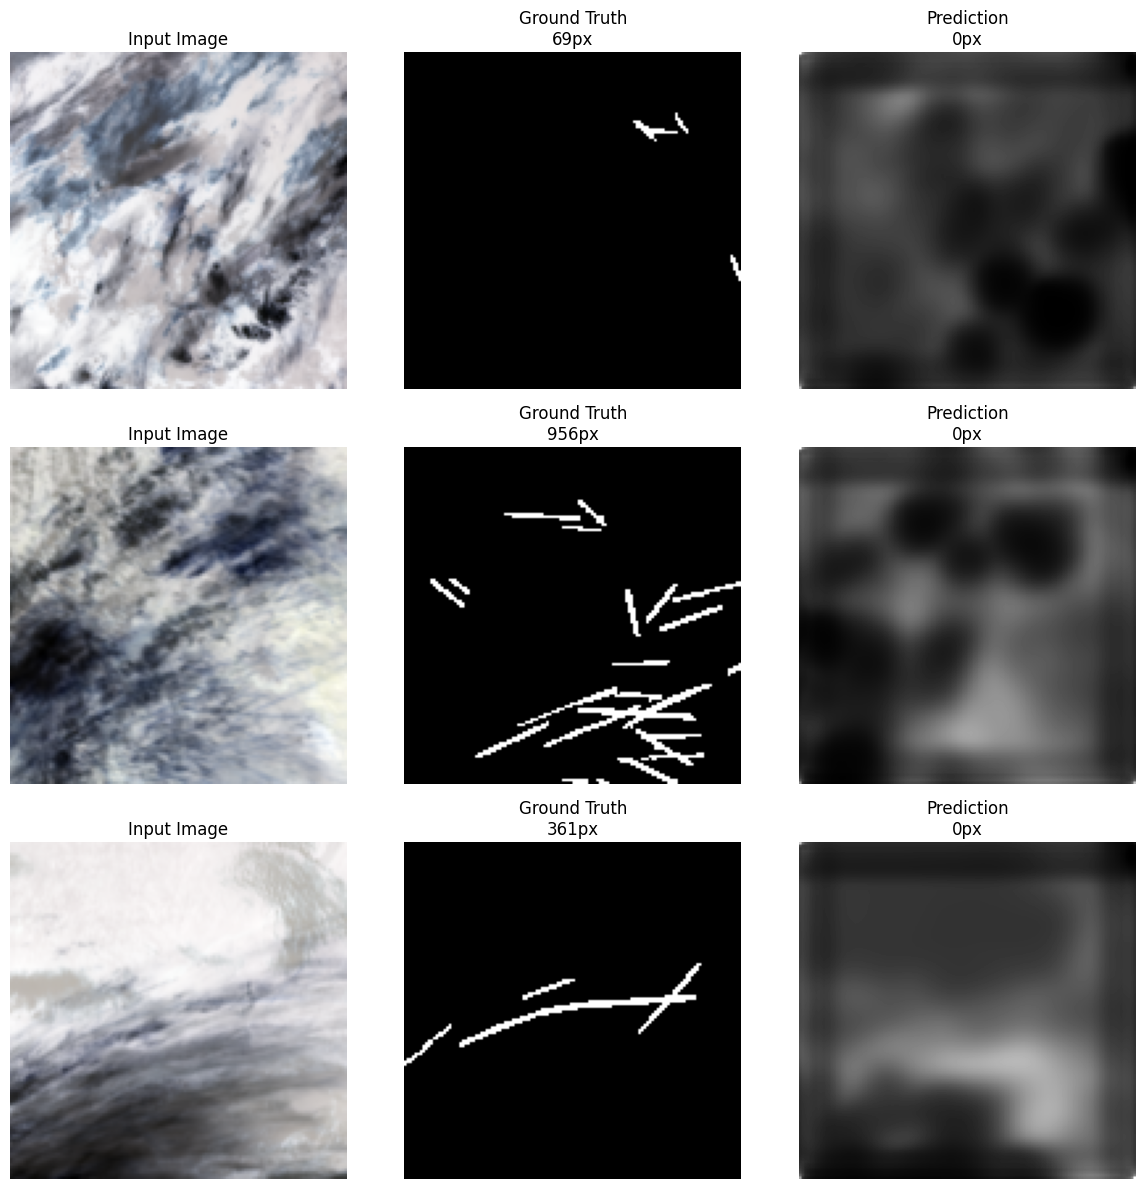

Model saved successfully!
Script completed!


In [4]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

# Configuration
CONFIG = {
    'img_height': 128,
    'img_width': 128,
    'batch_size': 16,
    'epochs': 20,
    'learning_rate': 1e-3,
    'random_seed': 42
}

# Set random seeds
tf.random.set_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

# Load metadata
print("Loading metadata...")
with open("/kaggle/input/google-research-identify-contrails-reduce-global-warming/train_metadata.json") as f:
    train_meta = json.load(f)

print(f"Training samples: {len(train_meta)}")

BASE_PATH = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
TRAIN_PATH = os.path.join(BASE_PATH, "train")

def debug_sample_structure(record_id):
    """Debug the actual file structure"""
    record_path = os.path.join(TRAIN_PATH, record_id)
    print(f"\n=== Debugging {record_id} ===")
    
    try:
        # Check what files exist
        files = os.listdir(record_path)
        print(f"Files in directory: {files}")
        
        # Check each file
        for file in files:
            file_path = os.path.join(record_path, file)
            data = np.load(file_path)
            print(f"  {file}: shape={data.shape}, dtype={data.dtype}, range=[{data.min():.3f}, {data.max():.3f}]")
            
            if 'mask' in file:
                print(f"    Unique values: {np.unique(data)}")
                print(f"    Non-zero count: {np.sum(data > 0)}")
                
    except Exception as e:
        print(f"Error: {e}")

def load_sample_safely(record_id):
    """Load sample without any OpenCV operations"""
    record_path = os.path.join(TRAIN_PATH, record_id)
    
    try:
        # Load all data
        band15 = np.load(os.path.join(record_path, "band_15.npy"))
        band14 = np.load(os.path.join(record_path, "band_14.npy")) 
        band11 = np.load(os.path.join(record_path, "band_11.npy"))
        human_pixel_masks = np.load(os.path.join(record_path, "human_pixel_masks.npy"))
        
        print(f"Loaded {record_id}:")
        print(f"  band15: {band15.shape}, {band15.dtype}")
        print(f"  band14: {band14.shape}, {band14.dtype}")
        print(f"  band11: {band11.shape}, {band11.dtype}")
        print(f"  masks: {human_pixel_masks.shape}, {human_pixel_masks.dtype}")
        print(f"  mask unique: {np.unique(human_pixel_masks)}")
        print(f"  mask non-zero: {np.sum(human_pixel_masks > 0)}")
        
        return band15, band14, band11, human_pixel_masks
        
    except Exception as e:
        print(f"Error loading {record_id}: {e}")
        return None, None, None, None

def preprocess_with_tf(band15, band14, band11, mask):
    """Preprocess using only TensorFlow operations"""
    # Use middle timestep
    t = band15.shape[2] // 2
    band15_t = band15[:, :, t]
    band14_t = band14[:, :, t] 
    band11_t = band11[:, :, t]
    
    # Convert to tensors
    band15_tensor = tf.convert_to_tensor(band15_t, dtype=tf.float32)
    band14_tensor = tf.convert_to_tensor(band14_t, dtype=tf.float32)
    band11_tensor = tf.convert_to_tensor(band11_t, dtype=tf.float32)
    mask_tensor = tf.convert_to_tensor(mask, dtype=tf.float32)
    
    # Normalize bands
    def normalize_tensor(tensor):
        tensor_min = tf.reduce_min(tensor)
        tensor_max = tf.reduce_max(tensor)
        return (tensor - tensor_min) / (tensor_max - tensor_min + 1e-8)
    
    band15_norm = normalize_tensor(band15_tensor)
    band14_norm = normalize_tensor(band14_tensor)
    band11_norm = normalize_tensor(band11_tensor)
    
    # Create RGB image
    image = tf.stack([band15_norm, band14_norm, band11_norm], axis=-1)
    
    # Handle mask shape
    if len(mask_tensor.shape) == 3:
        mask_tensor = tf.squeeze(mask_tensor)  # Remove channel dimension if present
    
    # Resize using TensorFlow
    image_resized = tf.image.resize(image, [CONFIG['img_height'], CONFIG['img_width']])
    mask_resized = tf.image.resize(tf.expand_dims(mask_tensor, axis=-1), 
                                 [CONFIG['img_height'], CONFIG['img_width']])
    
    # Convert mask to binary
    mask_binary = tf.cast(mask_resized > 0, tf.float32)
    mask_binary = tf.squeeze(mask_binary)  # Back to 2D
    
    return image_resized.numpy(), mask_binary.numpy()

# Debug first sample structure
print("Debugging first sample structure...")
debug_sample_structure(train_meta[0]['record_id'])

# Test loading and preprocessing on first sample
print("\nTesting load and preprocessing...")
band15, band14, band11, mask = load_sample_safely(train_meta[0]['record_id'])

if band15 is not None:
    image, processed_mask = preprocess_with_tf(band15, band14, band11, mask)
    print(f"Processed image: {image.shape}, range: [{image.min():.3f}, {image.max():.3f}]")
    print(f"Processed mask: {processed_mask.shape}, contrails: {np.sum(processed_mask > 0)}")
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title('Processed Image')
    axes[0].axis('off')
    
    axes[1].imshow(processed_mask, cmap='gray')
    axes[1].set_title(f'Processed Mask\n{np.sum(processed_mask > 0)} contrail pixels')
    axes[1].axis('off')
    
    # Show original mask for comparison
    original_mask = mask.squeeze() if len(mask.shape) == 3 else mask
    axes[2].imshow(original_mask, cmap='gray')
    axes[2].set_title(f'Original Mask\n{np.sum(original_mask > 0)} contrail pixels')
    axes[2].axis('off')
    
    plt.show()

def find_and_load_contrail_samples(metadata, num_to_check=100):
    """Find and load samples with contrails"""
    contrail_samples = []
    
    print(f"Searching for contrails in {num_to_check} samples...")
    
    for i, meta in enumerate(tqdm(metadata[:num_to_check])):
        record_id = meta['record_id']
        
        band15, band14, band11, mask = load_sample_safely(record_id)
        
        if mask is not None:
            # Check if mask has contrails
            contrail_count = np.sum(mask > 0)
            if contrail_count > 0:
                print(f"Found contrails in {record_id}: {contrail_count} pixels")
                
                # Preprocess
                image, processed_mask = preprocess_with_tf(band15, band14, band11, mask)
                
                if image is not None:
                    contrail_samples.append({
                        'image': image,
                        'mask': processed_mask,
                        'original_contrails': contrail_count
                    })
    
    print(f"Found {len(contrail_samples)} samples with contrails")
    return contrail_samples

# Find samples with contrails
contrail_data = find_and_load_contrail_samples(train_meta, num_to_check=1000)

if len(contrail_data) > 0:
    print(f"Successfully loaded {len(contrail_data)} contrail samples")
    
    # Extract images and masks
    train_images = np.array([sample['image'] for sample in contrail_data])
    train_masks = np.array([sample['mask'] for sample in contrail_data])
    
    print(f"Training images: {train_images.shape}")
    print(f"Training masks: {train_masks.shape}")
    print(f"Total contrail pixels: {np.sum(train_masks > 0)}")
    
    # Create model
    def create_unet_model(input_shape=(128, 128, 3)):
        inputs = layers.Input(shape=input_shape)
        
        # Encoder
        x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
        x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D(2)(x)
        
        x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D(2)(x)
        
        x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
        
        # Decoder
        x = layers.UpSampling2D(2)(x)
        x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
        
        x = layers.UpSampling2D(2)(x)
        x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
        
        outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
        
        model = keras.Model(inputs, outputs)
        return model
    
    # Create and compile model
    model = create_unet_model(input_shape=(CONFIG['img_height'], CONFIG['img_width'], 3))
    
    model.compile(
        optimizer=keras.optimizers.Adam(CONFIG['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.IoU(num_classes=2, target_class_ids=[1], name='iou')]
    )
    
    print("Model summary:")
    model.summary()
    
    # Add channel dimension to masks
    train_masks_expanded = np.expand_dims(train_masks, axis=-1)
    
    # Split data
    if len(train_images) > 5:
        train_im, val_im, train_mask, val_mask = train_test_split(
            train_images, train_masks_expanded, test_size=0.2, random_state=CONFIG['random_seed']
        )
        
        print(f"Training set: {train_im.shape}")
        print(f"Validation set: {val_im.shape}")
        
        # Train model
        print("Starting training...")
        history = model.fit(
            train_im, train_mask,
            validation_data=(val_im, val_mask),
            epochs=CONFIG['epochs'],
            batch_size=CONFIG['batch_size'],
            verbose=1
        )
        
        # Evaluate
        print("\nFinal Evaluation:")
        results = model.evaluate(val_im, val_mask, verbose=0)
        for name, value in zip(model.metrics_names, results):
            print(f"{name}: {value:.4f}")
        
        # Visualize predictions
        print("\nVisualizing predictions...")
        predictions = model.predict(val_im[:3], verbose=0)
        
        fig, axes = plt.subplots(3, 3, figsize=(12, 12))
        
        for i in range(3):
            # Input
            axes[i, 0].imshow(val_im[i])
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')
            
            # Ground Truth
            gt_mask = val_mask[i].squeeze()
            axes[i, 1].imshow(gt_mask, cmap='gray')
            axes[i, 1].set_title(f'Ground Truth\n{np.sum(gt_mask > 0)}px')
            axes[i, 1].axis('off')
            
            # Prediction
            pred = predictions[i].squeeze()
            axes[i, 2].imshow(pred, cmap='gray')
            axes[i, 2].set_title(f'Prediction\n{np.sum(pred > 0.5)}px')
            axes[i, 2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Save model
        model.save('contrail_model_final.h5')
        print("Model saved successfully!")
        
    else:
        print("Not enough samples for proper training")
        
else:
    print("No contrail samples found! Trying alternative approach...")
    
    # Load first few samples regardless of contrails
    print("Loading first 10 samples for testing...")
    test_samples = []
    
    for i in range(min(10, len(train_meta))):
        record_id = train_meta[i]['record_id']
        band15, band14, band11, mask = load_sample_safely(record_id)
        
        if band15 is not None:
            image, processed_mask = preprocess_with_tf(band15, band14, band11, mask)
            test_samples.append((image, processed_mask))
    
    if test_samples:
        print(f"Loaded {len(test_samples)} test samples")
        # Show what we have
        for i, (image, mask) in enumerate(test_samples):
            print(f"Sample {i}: image {image.shape}, mask {mask.shape}, contrails: {np.sum(mask > 0)}")

print("Script completed!")